# 7 Qubit Error Detection Surface Code

First creating the section of the circuit to detect for phase flip errors

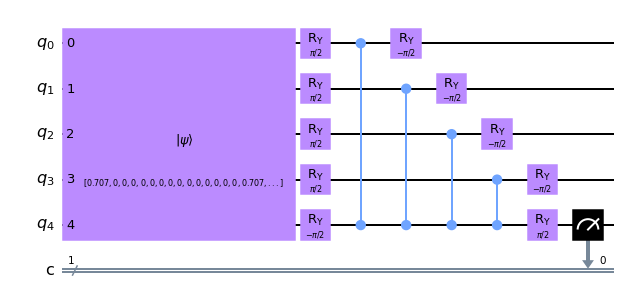

In [2]:
import numpy as np
from math import *
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor
initial_state = []
#Initialize to logical 0
for i in range(0,32):
    if i == 0:
        initial_state.append(1/np.sqrt(2))
    elif i == 15:
        initial_state.append(1/np.sqrt(2))
    else:
        initial_state.append(0)
        

sc = QuantumCircuit(5,1)
sc.initialize(initial_state, sc.qubits)



#Surface code
for i in range(0,4):
    sc.ry(pi/2,i)

sc.ry(-pi/2,4)

for i in range(0,4):
    sc.cz(i,4)

for i in range(0,4):
    sc.ry(-pi/2,i)

sc.ry(pi/2,4)

sc.measure(4,0) #measure ancilla qubit
sc.draw('mpl')


{'0': 1000}


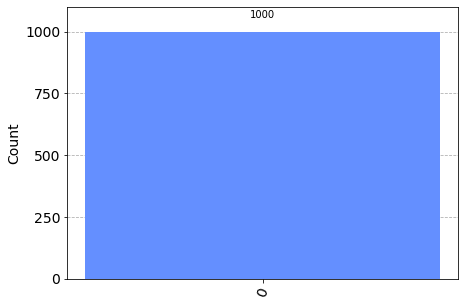

In [3]:
backend = BasicAer.get_backend('qasm_simulator') #The device to run on
result = backend.run(transpile(sc,backend), shots = 1000).result()
counts = result.get_counts() #Get our result


print(counts)
plot_histogram(counts)

Now creating bit flip section of the circuit

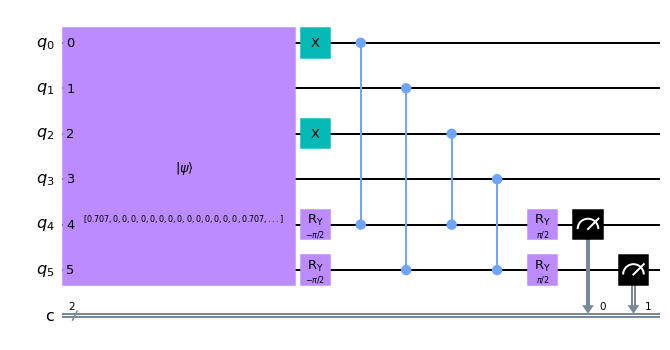

In [52]:
initial_state = []
#Initialize to logical 0
for i in range(0,64):
    if i == 0:
        initial_state.append(1/np.sqrt(2))
    elif i == 15:
        initial_state.append(1/np.sqrt(2))
    else:
        initial_state.append(0)

sc2 = QuantumCircuit(6,2)
sc2.initialize(initial_state, sc2.qubits)
 #Initialize circuit


    
sc2.ry(-pi/2,4)
sc2.ry(-pi/2,5)

sc2.x(0)
sc2.x(2)

sc2.cz(0,4)
sc2.cz(1,5)
sc2.cz(2,4)
sc2.cz(3,5)

sc2.ry(pi/2,4)
sc2.ry(pi/2,5)



sc2.measure(4,0)
sc2.measure(5,1)

sc2.draw('mpl')

{'00': 1000}


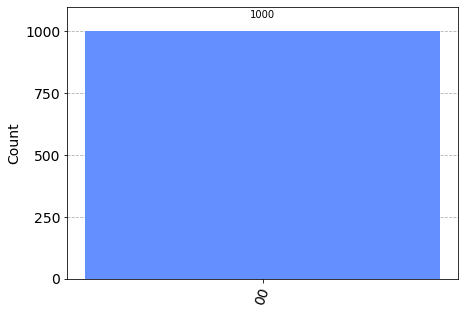

In [53]:
backend = BasicAer.get_backend('qasm_simulator') #The device to run on
result = backend.run(transpile(sc2,backend), shots = 1000).result()
counts = result.get_counts() #Get our result


print(counts)
plot_histogram(counts)

# Full circuit

Creating the full surface code with 7 qubits.

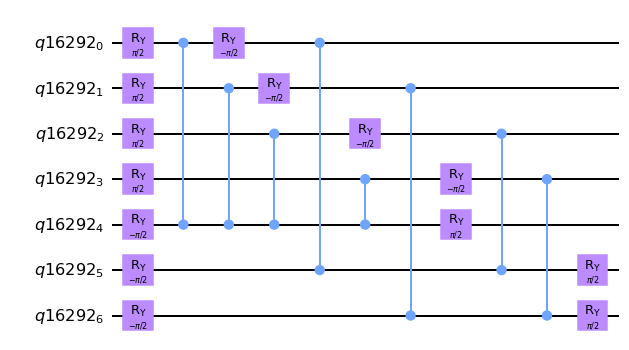

In [56]:
import numpy as np
from math import *
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor

# Initialize a 7 qubit quantum register named `q`
q = QuantumRegister(7)

# Create a Quantum Circuit using the quantum register
sc = QuantumCircuit(q)


# Surface code
for i in range(0,4):
    # Apply a Ry gate with pi/2 angle to qubits 0 to 3
    sc.ry(pi/2,q[i])

# Apply a Ry gate with -pi/2 angle to qubit 4
sc.ry(-pi/2,q[4])

# Apply a CZ gate between qubits 0 to 3 and qubit 4
for i in range(0,4):
    sc.cz(q[i],q[4])

# Apply a Ry gate with -pi/2 angle to qubits 0 to 3
for i in range(0,4):
    sc.ry(-pi/2,q[i])

# Apply a Ry gate with pi/2 angle to qubit 4
sc.ry(pi/2,q[4])

# Apply a Ry gate with -pi/2 angle to qubits 5 and 6
sc.ry(-pi/2,q[5])
sc.ry(-pi/2,q[6])

# Apply a CZ gate between qubits 0 to 3 and qubits 5 and 6
sc.cz(q[0],q[5])
sc.cz(q[1],q[6])
sc.cz(q[2],q[5])
sc.cz(q[3],q[6])

# Apply a Ry gate with pi/2 angle to qubits 5 and 6
sc.ry(pi/2,q[5])
sc.ry(pi/2,q[6])

# Draw the circuit
sc.draw('mpl')



We can now use this surface code to see how measurements change when different errors are present.

In [86]:
backend = BasicAer.get_backend('qasm_simulator') #The device to run on


 #create 7 qubit surface code gate
sc_gate = sc.to_gate()
q1 = QuantumRegister(7)
c1 = ClassicalRegister(3)
c2 = ClassicalRegister(4)
for i in range(0,4):
    #Create a new circuit
    new_circ = QuantumCircuit(q1,c1) 
    new_circ.h(1)
    new_circ.h(3)
    #Run one surface code cycle to initialize logical0
    new_circ.append(sc_gate, [0,1,2,3,4,5,6]) 
    
    #bit flip errors
    new_circ.x(i)
    
    new_circ.append(sc_gate, [0,1,2,3,4,5,6]) #7 qubit surface code
    
    new_circ.measure(4,0) #measure ancilla qubits
    new_circ.measure(5,1)
    new_circ.measure(6,2)
    
    new_circ.h(1)
    new_circ.h(3)
    #new_circ.append(sc_gate,[0,1,2,3,4,5,6])
    new_circ.add_register(c2)
    for j in range(0,4):
        new_circ.measure(j, c2[j])
    result = backend.run(transpile(new_circ,backend), shots = 1000).result()
    counts = result.get_counts() #Get our result
    
    
    print(f'Bit-flip error on qubit {i}',counts)

Bit-flip error on qubit 0 {'0001 010': 1000}
Bit-flip error on qubit 1 {'0000 100': 1000}
Bit-flip error on qubit 2 {'0100 010': 1000}
Bit-flip error on qubit 3 {'0000 100': 1000}


## Noise Model

Analyzing the 7 qubit error detection code with a Pauli-error noise model.

Logical0 initial state
Runtime: 4.3 seconds


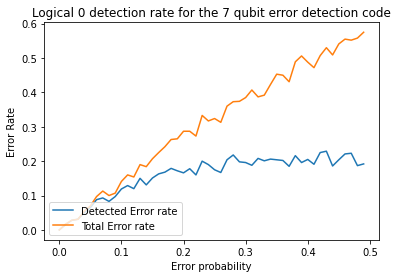


Logical+ initial state
Runtime: 6.1 seconds


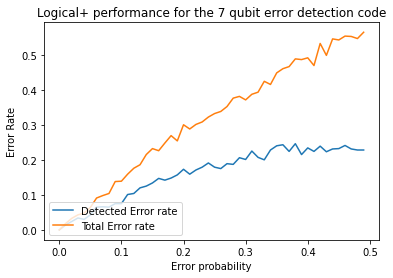

In [85]:
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from qiskit import *
from qiskit_aer.noise import pauli_error
# ------------------------------------------------------------------



# ------------------------------------------------------------------
# Hard-coded constants
random.seed(42)     # For reproducibility
Nshots = 1000

q = QuantumRegister(7)              # Create 7-qubit quantum register
c = ClassicalRegister(3)            # Create 3-bit classical register
cr = ClassicalRegister(4)           # Create 4-bit classical register to measure the data qubits
simulator = Aer.get_backend('qasm_simulator')   # Choose simulator

error_probs = np.arange(0, 0.5, 0.01)
# ------------------------------------------------------------------



# ------------------------------------------------------------------
# Subroutine to loop over pauli_error probabilities
# Argument 'init' chooses between |0> and |+> initial state
def scan_probs(init):
    detection_rates = []
    err_rates = []
    for p_err in error_probs:
        sc = QuantumCircuit(q, c)  # Create quantum circuit
        
            
        #Run one surface code cycle to initialize logical0 or logical+
        if init == 'plus':
            sc.h(q[1])
            sc.h(q[3])
        sc.append(sc_gate, [0,1,2,3,4,5,6]) 

        # Construct a 1-qubit bit-flip error
        error = pauli_error([('X', 0.5 * p_err),
                             ('Z', 0.5 * p_err),
                             ('I', 1.0 - p_err)])

        # Combine the circuit and the error channel
        for i in range(0,4):
            sc.append(error, [i])
    
        #Append our 7 qubit surface code entangling gate
        sc.append(sc_gate, [0,1,2,3,4,5,6])

        # Measure the three ancilla qubits
        sc.measure(q[4],c[0]) #measure ancilla qubits
        sc.measure(q[5],c[1])
        sc.measure(q[6],c[2])

        #Decode for logical+
        if init == 'plus':
            sc.h(1)
            sc.h(3)
            
        # Add the classical register to the quantum circuit
        sc.add_register(cr)
        # Check the state of the initial qubits
        for i in range(0,3):
            sc.measure(q[i], cr[i])

        # Reproducibly execute the circuit on the simulator
        seed = random.randrange(0, int(1e6))
        result = execute(sc, simulator, shots=Nshots,
                         seed_simulator=seed).result()

        # Get the counts from the result
        counts = result.get_counts()
        
        #Create a list of expected detection keys
        if init == 'zero':
            expected_keys = ['0001 010', '0010 100', '0100 010', '1000 100', '0011 110', '1100 110', '1001 110', '0110 110']
        else:
            expected_keys = ['0001 010', '0100 100', '0010 001','1000 001', '0001 011', '0100 101',
                             '0100 011', '1000 101', '0100 110', '0001 110'] #ToDo are these expected keys correct?
        
        correct_detect = 0
        total_err = 0
        counts_dict = dict(counts)
        for key, value in counts_dict.items():
            if key in expected_keys:
                correct_detect += value
            if key[:4] != '0000':
                total_err += value

        detection_rates.append(correct_detect / float(Nshots))
        err_rates.append(total_err / float(Nshots))
        #print("%.3g %.3g %.3g" % (p_err, success_rates[-1], uncorr_rates[-1]))

    return detection_rates, err_rates

for state in ['zero','plus']:
    runtime = -time.time()
    if state == 'zero':
        print("Logical0 initial state")
    else:
        # Blank line in output to separate results
        print("\nLogical+ initial state")

    detection_rates, err_rates = scan_probs(state)

    # Print runtime here to ignore time spent looking at plot
    runtime += time.time()
    print("Runtime: %0.1f seconds" % runtime)

    if state == 'zero':
      title = 'Logical 0 detection rate for the 7 qubit error detection code'
    else:
      title = 'Logical+ performance for the 7 qubit error detection code'
    
#     total_errors = [1 - rate for rate in err_rates]
    # Plot the error rate as a function of the error probability
    plt.plot(error_probs, detection_rates, label='Detected Error rate')
    plt.plot(error_probs, err_rates, label='Total Error rate')
    plt.title(title)
    plt.xlabel('Error probability')
    plt.ylabel('Error Rate')
    plt.legend(loc='lower left')
    plt.show()